<a href="https://colab.research.google.com/github/asminimulin/cv-course/blob/main/02-image-linear-classification/Linear_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset with Pytorch



## Load the data

In [235]:
from functools import partial
from torch import Tensor
import torch

import matplotlib.pyplot as plt

In [366]:
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from PIL import Image


# Define transformation for each image
transform  = transforms.Compose([
    transforms.Lambda(lambda x: np.array(x).flatten().astype(np.float32) / 255) #Stretch image into row [32,32,3] -> [3072]
])

# Download a CIFAR10 dataset
dataset = datasets.CIFAR10("/content",
                           train=True,
                           transform = transform,
                           download=False)


## Make sure there is no problems with dtype overflow

In [367]:
print(dataset[0][0].dtype)

float32


## Split dataset & define dataloaders

torch.Size([500, 3072]) torch.Size([500])


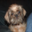

5

In [401]:
train_ds, val_ds, _= random_split(dataset, [25000,10000 ,15000])
# Hint: Perform debug on smaller subset

batch_size = 500

train_loader = DataLoader(train_ds, batch_size = batch_size)
val_loader = DataLoader(val_ds, batch_size = 15000)

# Display one image
for images, class_nums in train_loader:
  print (images.shape,class_nums.shape) # class_nums are tensor!
  grayscale = np.uint8(images[0].reshape((32, 32, 3)).numpy() * 255)
  display(Image.fromarray(grayscale, 'RGB'),class_nums[0].item()) 
  break


# Implement LinearClassifier class for CIFAR10

In [370]:
class LinearClassifier:
  def __init__(self, labels):
    self.__labels = labels
    self.__classes_num = len(labels)
    # self.__weights = torch.from_numpy((np.random.randn(1024, self.__classes_num) * 0.0001).astype(np.float32))
    self.__w_unnormalized = torch.randn(1025, len(labels), dtype=torch.float32, requires_grad=True)
    self.__weights = self.__w_unnormalized * 0.0001

  
  def train(self, images: np.array, labels: np.array, learning_rate = 1e-6):
    """
      Arguments:
        images  (numpy.array): collection of objects (batch)
        labels  (numpy.array): collection of integer 
        representing a class number for objects from x
    
    """
    images = torch.from_numpy(self.__add_ones(images.numpy()).astype(np.float32))
    # images = torch.from_numpy(images)

    loss_val, grad = self.__loss(images, labels)

    self.__weights -= (grad * learning_rate)

    return loss_val/images.shape[0]


  def predict(self,x):
    # x = torch.from_numpy(x.astype(np.float32))
    x = torch.from_numpy(self.__add_ones(x).astype(np.float32))
    scores = x @ self.__weights # (256, 1025) * (1025, 10)
    return torch.argmax(scores,axis = 1)


  __weights: np.array  # np.array of shape (1024, 10)


  def __loss(self, images, labels):
    """
      Arguments:
        images  (numpy.array or torch.Tensor): collection of objects (batch)
        labels  (numpy.array or torch.Tensor): collection of integer 
        representing a class number for objects from x
    
    """

    # Calculate Multiclass SVM or Cross-entropy loss over a batch 
    # loss = self.__calc_svm_loss(images, labels, self.__weights)
    loss = self.__calc_mce_loss(images, labels, self.__weights)

    # Calculate gradients (dL/dW) and store it in dW
    # grad = self.__calc_numeric_grad(partial(self.__calc_svm_loss, images, labels), loss)
    loss.backward(retain_graph=True)
    grad = self.__w_unnormalized.grad

    return loss, grad


  @staticmethod
  def __add_ones(images):
    return np.append(images, np.ones((images.shape[0], 1)), axis=1)


  @staticmethod
  def __calc_svm_loss(images: np.array, labels: np.array, weights: np.array):
    # images.shape = (N, S)
    # self.__wights.shape = (S, 10)
    # (N, S) * (S, 10) = (N, 10)
    # scores is two-dimensional np.array, each row contains scores of every class
    scores = images @ weights
    
    correct_scores = np.zeros((scores.shape[0], 1))
    for i, (label, score_arr) in enumerate(zip(labels, scores)):
      correct_scores[i][0] = score_arr[label] + 1

    diffs = correct_scores - scores
    np.clip(diffs, 0, max(0, np.max(diffs)), out=diffs)
    return np.sum(diffs)


  @staticmethod
  def __calc_mce_loss(images: Tensor, labels: Tensor, weights: Tensor):
    scores = images @ weights

    # print(scores[:5])
    scores_exp = torch.exp(scores)
    # print(scores_exp[:5])
    scores_sums = torch.sum(scores_exp, dim=1, keepdim=True)
    # print(scores_sums[:5])
    scores_probabilities = scores_exp / scores_sums
    # print(scores_probabilities[:5])
    # print(torch.sum(scores_probabilities, dim=1)[:5])

    return (-torch.log(torch.gather(scores_probabilities, dim=1, index=labels.reshape((labels.shape[0], 1))))).sum()
    # return scores.sum()


  def __cals_analytic_grad(self):
    pass

  def __calc_numeric_grad(self, calc_loss, current_loss: float, delta=0.0001):
    grad = [[0] * self.__weights.shape[1]] * self.__weights.shape[0]
    for i in range(self.__weights.shape[0]):
      for j in range(self.__weights.shape[1]):
        d_weights = np.copy(self.__weights)
        d_weights[i, j] += delta
        loss_diff = calc_loss(d_weights) - current_loss
        grad[i][j] = (loss_diff) / delta
    return np.array(grad)


In [371]:
def my_test():
  # print(dataset.classes)
  # for images, class_nums in train_loader:
  #   print(len(images), len(class_nums))
  #   print(class_nums.shape)
  #   return
  #   print(class_nums[:15], min(class_nums), max(class_nums))
  #   for tensor, label in zip(images[:15], class_nums[:15]):
  #     print(f"Class={label}-{dataset.classes[label]}")
  #     display(Image.fromarray((tensor.numpy().reshape(32, 32) * 255).astype(np.uint8), 'L'));
  #   break
  model = LinearClassifier(dataset.classes)
  for images, classes in train_loader:
    return model.train(images, classes)
  
my_test()

RuntimeError: ignored

In [372]:
l0 = torch.from_numpy(np.array(
    [0, 2]
))

k0 = torch.from_numpy(np.array(
    [[1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]]
))

k0[]

SyntaxError: ignored

In [424]:
def add_ones_to_tensor(tensor: Tensor):
  return torch.from_numpy(np.append(tensor.numpy(), np.ones((tensor.shape[0], 1), dtype=np.float32), axis=1))

class LinearClassifier(torch.nn.Module):
  def __init__(self, input_dim=3073, output_dim=10):
    super(LinearClassifier, self).__init__()
    self.linear = torch.nn.Linear(input_dim, output_dim)
  
  def forward(self, x):
    return self.linear(x)


In [425]:
model = LinearClassifier()
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.25)

all_loss = []

for epoch in range(300):
  print(f"Epoch: {epoch}")
  for (images, classes) in train_loader:
    images = add_ones_to_tensor(images.type(torch.float32) / (255))
    output = model(images)

    loss = criterion(output, classes.view(-1))
    all_loss.append(loss.item())
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    break

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100

In [426]:
for images, labels in val_loader:
  images = add_ones_to_tensor(images.type(torch.float32) / 255)
  probabilities = model.forward(images)
  print(probabilities.shape)
  pred = torch.argmax(probabilities, dim=1)
  print(pred.shape)
  acc = (pred.numpy() == labels.numpy()).sum() / pred.shape[0]
  print(f"accuracy = {acc}")
  

torch.Size([10000, 10])
torch.Size([10000])
accuracy = 0.3089


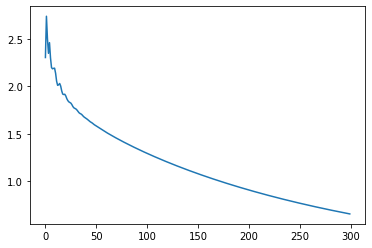

In [427]:
plt.plot(all_loss)

In [ ]:
for images, labels in val_loader:
  images = 

# Train model

## Function for accuracy checking

Don't change this code

In [111]:
from sklearn.metrics import accuracy_score

def validate(model,dataloader):
  y_predicted = np.array([])
  y_gtrue = np.array([])
  for images, class_nums in dataloader:
    index = model.predict(images.numpy())
    y_predicted = np.append(y_predicted,index) 
    y_gtrue = np.append(y_gtrue,class_nums.numpy()) 
  return accuracy_score(y_gtrue, y_predicted)

## Train loop
Let's train our model

In [224]:

model = LinearClassifier(dataset.classes)
best_accuracy = 0
for epoch in range(25):
  print(f"Starting epoch={epoch}")
  for images, class_nums in train_loader:
    loss = model.train(images, class_nums)
  accuracy = validate(model,val_loader)
  if best_accuracy < accuracy:
    best_accuracy = accuracy
  print(f"Epoch {epoch} Loss: {loss}, Accuracy:{accuracy}")

print(f"Best accuracy is {best_accuracy}")

Starting epoch=0
Epoch 0 Loss: 2.2402150630950928, Accuracy:0.24
Starting epoch=1
Epoch 1 Loss: 2.1346638202667236, Accuracy:0.225
Starting epoch=2
Epoch 2 Loss: 1.9985244274139404, Accuracy:0.217
Starting epoch=3
Epoch 3 Loss: 2.019589900970459, Accuracy:0.197
Starting epoch=4
Epoch 4 Loss: 2.340911388397217, Accuracy:0.19
Starting epoch=5
Epoch 5 Loss: 2.1221439838409424, Accuracy:0.221
Starting epoch=6
Epoch 6 Loss: 2.505711793899536, Accuracy:0.207
Starting epoch=7
Epoch 7 Loss: 2.397432327270508, Accuracy:0.218
Starting epoch=8
Epoch 8 Loss: 2.68744158744812, Accuracy:0.191
Starting epoch=9
Epoch 9 Loss: 2.6366589069366455, Accuracy:0.204
Starting epoch=10
Epoch 10 Loss: 4.097376346588135, Accuracy:0.191
Starting epoch=11
Epoch 11 Loss: 3.4222781658172607, Accuracy:0.182
Starting epoch=12
Epoch 12 Loss: 3.5858991146087646, Accuracy:0.155
Starting epoch=13
Epoch 13 Loss: 2.3892457485198975, Accuracy:0.206
Starting epoch=14
Epoch 14 Loss: 2.4798598289489746, Accuracy:0.193
Starting 

KeyboardInterrupt: ignored

# Check model on test dataset

You must get accuracy above 0.35


In [ ]:
test_dataset = datasets.CIFAR10("content",
                           train=False,
                           transform = transform, # Transforms stay the same
                           download=True)

test_loader = DataLoader(test_dataset, batch_size = batch_size)

accuracy = validate(model,test_loader)
print(f"Accuracy on test:{accuracy}")


# Place for brief conclusion
Feel free to describe troubles here.


...



# Ideas for extra work

- Implenment CrossEntropyLoss function
- Implement bias trick
- Add regularization to SVM loss
- Find best learning rate and regularization strength using Cross-Validation
- Normalize data


 